# **<center>Using CNN to stopping the car when it comes off the road<center>**
    
In this notebook, you can download images obtained with the donkey car. You can use them to launch a training in order to get a model for the donkey car.
Several options are available :

- The number of image to learn from
- The possibility to invert them to also learn turning right
    
    

In [1]:
import json
import shutil
import random
import pathlib
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import IPython.display as display

import mlflow
import mlflow.tensorflow
import mlflow.keras

import tensorflow as tf

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import MSLE, MAE, MSE
from tensorflow.keras.losses import MSE, MSLE
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from xebikart.images import transformer as T
import xebikart.dataset as dataset

from sklearn.model_selection import train_test_split

%matplotlib inline

using donkey version: 2.5.8 ...


In [2]:
tf.__version__

'1.14.0'

In [3]:
tf.test.is_gpu_available()

False

Eager Execution allows to evaluate operations immediately without building graphs
note : Only needed when not using TF 2.0

In [4]:
tf.enable_eager_execution()

In [5]:
# parameters
# dataset parameters
tubes_root_folder = 'file:/workspace/xebikart-ml-tubes'
tubes_folders_road = ["tub.v7.01", "tub.v7.02"]
tubes_folders_exit = ["tub.v5.01", "tub.v5.02"]#, "tub.v5.03", "tub.v5.04"]

test_size=0.2

# training parameters
batch_size = 32
shuffle_size = 200
n_epochs = 20
learning_rate = 1e-3

# Load data

Download tubes from : https://github.com/xebia-france/xebikart-ml-tubes

In [6]:
%%capture
road_tubes_df = dataset.get_tubes_df(tubes_root_folder, tubes_folders_road, tubes_extension=".tar.gz")
road_tubes_df['label'] = 0
exit_tubes_df = dataset.get_tubes_df(tubes_root_folder, tubes_folders_exit, tubes_extension=".tar.gz")
exit_tubes_df['label'] = 1
road_tubes_df = road_tubes_df.rename(columns={"cam/image_array": "images_path"})
exit_tubes_df = exit_tubes_df.rename(columns={"cam/image_array": "images_path"})
tubes_df = pd.concat([road_tubes_df, exit_tubes_df])
tubes_df = tubes_df.drop(["user/angle", "user/throttle", "user/mode", "timestamp"], axis=1)
tubes_df.head()

#### **- Display some examples**

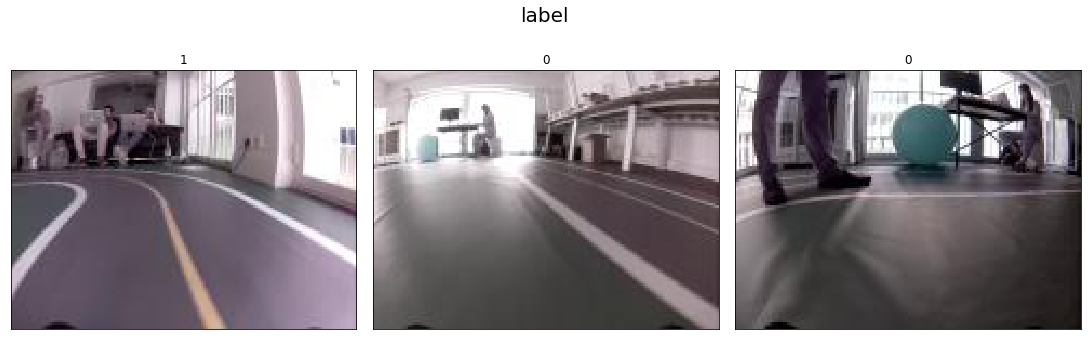

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(15,5), constrained_layout=True)
fig.suptitle("label", fontsize=20)

for n, sample in tubes_df.sample(3).reset_index().iterrows():
    random_image_path = sample["images_path"]
    label = sample["label"]
    image = mpimg.imread(random_image_path) 
    axs[n].set_title(label)
    axs[n].imshow(image)
    axs[n].get_xaxis().set_visible(False)
    axs[n].get_yaxis().set_visible(False)

#### **- Display some sample distribution**

<function matplotlib.pyplot.show(*args, **kw)>

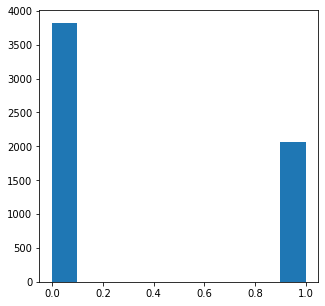

In [8]:
fig = plt.figure(figsize=(5,5))
plt.hist(tubes_df.label)
plt.show

# Preprocessing Images

In [9]:
crop_fn = T.generate_crop_fn(left_margin=0, width=160, height_margin=80, height=40)

def load_augmentation_preprocess(image_path):
    tf_image = T.read_image(image_path)
    tf_image = T.normalize(tf_image)
    tf_image = tf.image.rgb_to_grayscale(tf_image)
    tf_image = crop_fn(tf_image)
    return tf_image

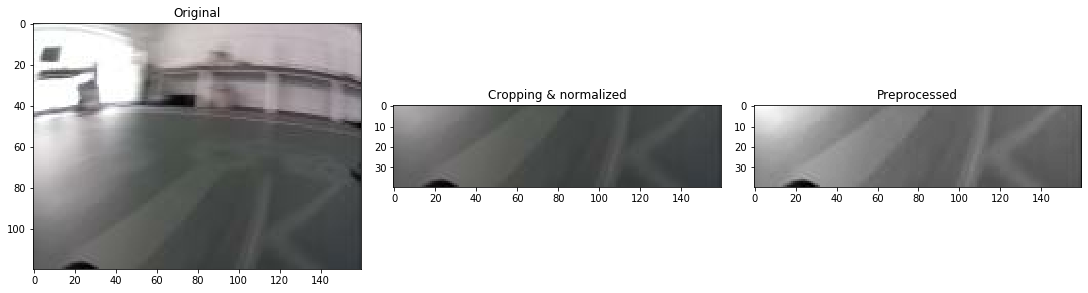

In [10]:
random_image_path = tubes_df.sample()["images_path"].values[0]

tf_image_original   = T.read_image(random_image_path)
tf_image_normalized = T.normalize(tf_image_original)
tf_image_cropped    = crop_fn(tf_image_normalized)
tf_image_grayscaled = tf.image.rgb_to_grayscale(tf_image_cropped)

fig, axs = plt.subplots(1, 3, figsize=(15,15), constrained_layout=True)
axs[0].set_title("Original")
axs[0].imshow(tf_image_original)
axs[1].set_title("Cropping & normalized")
axs[1].imshow(tf_image_cropped)
axs[2].set_title("Preprocessed")
axs[2].imshow(tf_image_grayscaled[:,:,0],cmap='gray')
plt.show()

# Build a dataset of images

#### **- Split data into test/train datasets**

Note : We only use angle as label

In [11]:
images_path = tubes_df["images_path"].tolist()
label = tubes_df["label"].tolist()

In [12]:
train_images_path, test_images_path, train_metas, test_metas = train_test_split(images_path, label, test_size=test_size)
print('Train set :', len(train_images_path), 'images')
print('Test set :', len(test_images_path), 'images')

Train set : 4708 images
Test set : 1177 images


#### **- Create tensor for train and test datasets**

In [13]:
def input_fn(filepath, label, BATCH_SIZE = 32, SHUFFLE_SIZE = 200, NUM_EPOCHS = 50):
    ds_x = tf.data.Dataset.from_tensor_slices(filepath)
    ds_x = ds_x.map(load_augmentation_preprocess)
    ds_y = tf.data.Dataset.from_tensor_slices(label)
    ds_x_y = tf.data.Dataset.zip((ds_x, ds_y)).shuffle(SHUFFLE_SIZE).repeat(NUM_EPOCHS).batch(BATCH_SIZE).prefetch(1)
    
    return ds_x_y

In [14]:
ds_train = input_fn(train_images_path, train_metas)
ds_test = input_fn(test_images_path, test_metas)

# Build Model

In [31]:
model = Sequential()

model.add(Conv2D(16, (5), activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01), input_shape=(40, 160,1)))
model.add(MaxPooling2D(3, 3))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model.add(MaxPooling2D(3))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.3))
#model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 36, 156, 16)       416       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 52, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 16, 32)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 1, 14, 64)         18496     
_________________________________________________________________
flatten_2 (Flatten)          (None, 896)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)              

In [32]:
model.compile(optimizer=Adam(learning_rate=learning_rate, decay=learning_rate/n_epochs), loss="binary_crossentropy")

In [33]:
mlflow.set_experiment("detect_road_exit")

with mlflow.start_run():
    mlflow.log_params({
        "images_exit": str(tubes_folders_exit),
        "images_road": str(tubes_folders_road),
        "nb_images": len(train_images_path),
        "epochs": n_epochs,
        "batch_size": batch_size,
        "learning_rate": learning_rate
    })
    mlflow.tensorflow.autolog()
    history = model.fit(x=ds_train,
                    steps_per_epoch=len(train_metas)//batch_size,
                    epochs=n_epochs,
                    verbose=1,
                    validation_data=ds_test,
                    validation_steps=len(test_metas)//batch_size)

Epoch 1/20
147/147 [==============================] - 7s 45ms/step - loss: 3.2334 - val_loss: 0.6228
Epoch 2/20
147/147 [==============================] - 6s 38ms/step - loss: 0.5717 - val_loss: 0.5403
Epoch 3/20
147/147 [==============================] - 6s 39ms/step - loss: 0.5103 - val_loss: 0.4545
Epoch 4/20
147/147 [==============================] - 6s 40ms/step - loss: 0.4297 - val_loss: 0.3460
Epoch 5/20
147/147 [==============================] - 6s 41ms/step - loss: 0.3366 - val_loss: 0.3600
Epoch 6/20
147/147 [==============================] - 6s 41ms/step - loss: 0.3010 - val_loss: 0.2862
Epoch 7/20
147/147 [==============================] - 6s 41ms/step - loss: 0.2847 - val_loss: 0.2654
Epoch 8/20
147/147 [==============================] - 6s 41ms/step - loss: 0.2721 - val_loss: 0.2621
Epoch 9/20
147/147 [==============================] - 6s 42ms/step - loss: 0.2641 - val_loss: 0.2451
Epoch 10/20
147/147 [==============================] - 6s 43ms/step - loss: 0.2484 - val_lo

In [34]:
# load model
# cnn_model = mlflow.keras.load_model("runs:/5d890004534c44f1880a0da3011c80d0/model")

# Plot loss

In [35]:
def plot_results(history):
    hist_df = pd.DataFrame(history.history)
    hist_df.columns=['loss','val_loss']
    hist_df.index = np.arange(1, len(hist_df)+1)
    fig = plt.figure(figsize=(10,5))
    plt.plot(hist_df.val_loss, lw=3, label='Validation Loss')
    plt.plot(hist_df.loss, lw=3, label='Training Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.grid()
    plt.legend(loc=0)

    plt.show()

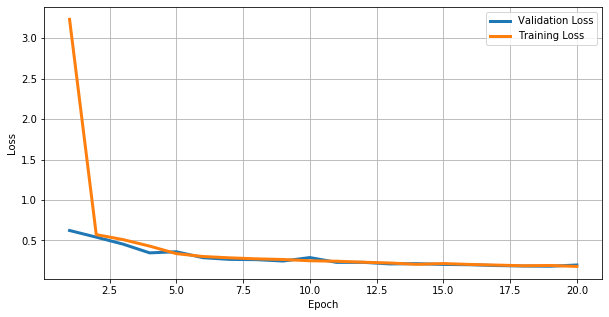

In [36]:
plot_results(history)

# Evaluation

In [37]:
test_pred = model.predict(ds_test, steps=len(test_metas)//batch_size)

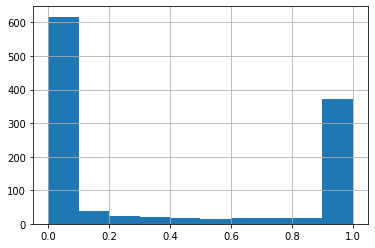

In [38]:
df = pd.DataFrame(test_pred, columns = ['label'])
df.label.hist()

# Display prediction

In [ ]:
random_image_path = tubes_df.sample()["images_path"].values[0]
ds_test = input_fn(random_image_path, test_metas)